#**유통 판매량 예측 및 재고 최적화**

* 분석 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1. 환경 설정**

In [ ]:
import os

# 환경에 따라 path 설정
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    path = '/content/drive/MyDrive/project/'  # 코랩 경로
else:
    path = ''  # 로컬 경로

print(f'현재 작업 경로: {path}')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

#### 1) 데이터로딩

In [ ]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

In [ ]:
# oil_price nan 처리
oil_price['WTI_Price'] = oil_price['WTI_Price'].interpolate(method='linear')
oil_price.iloc[0, 1] = oil_price.iloc[1, 1]

In [ ]:
# stores 미네소타앞 \t 처리
stores.State = stores.State.str.replace('\t', '')

#### 2) 기본 정보 조회

In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57558 entries, 0 to 57557
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           57558 non-null  datetime64[ns]
 1   Store_ID       57558 non-null  int64         
 2   CustomerCount  57558 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.3 MB


In [ ]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Product_ID    16 non-null     int64 
 1   Product_Code  16 non-null     object
 2   SubCategory   16 non-null     object
 3   Category      16 non-null     object
 4   LeadTime      16 non-null     int64 
 5   Price         16 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 896.0+ bytes


In [ ]:
products.sort_values(by='Product_ID') # 3, 12, 42

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
13,3,DB001,Beverage,Drink,2,8
10,5,FB001,BAKERY,Food,2,6
12,7,HC001,Cleaning,Household Goods,2,15
11,8,FM001,Yogurt,Food,2,4
8,10,GE001,EGGS,Grocery,2,5
7,11,FF001,Frozen,Food,2,29
14,12,GA001,Milk,Food,2,6
3,15,HK002,Kitchen,Household Goods,2,41
2,16,HK001,Kitchen,Household Goods,2,23
0,20,HG001,Gardening Tools,Household Goods,2,50


In [ ]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Store_ID    54 non-null     int64 
 1   City        54 non-null     object
 2   State       54 non-null     object
 3   Store_Type  54 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 1.8+ KB


In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 934275 entries, 0 to 934274
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Date        934275 non-null  datetime64[ns]
 1   Store_ID    934275 non-null  int64         
 2   Qty         934275 non-null  float64       
 3   Product_ID  934275 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 28.5 MB


In [ ]:
oil_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       825 non-null    datetime64[ns]
 1   WTI_Price  825 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 13.0 KB


# **2.데이터 탐색**

## **(0) 데이터 병합**

In [ ]:
data = pd.merge(sales, orders, how='left', on=['Date', 'Store_ID'])
data = pd.merge(data, products, how='left', on=['Product_ID'])
data = pd.merge(data, stores, how='left', on=['Store_ID'])
data = pd.merge(data, oil_price, how='left', on=['Date'])

### 1) 시간 관련 데이터 추가

In [ ]:
data['year'] = data['Date'].dt.year
data['weekday'] = data['Date'].dt.weekday
data['month'] = data['Date'].dt.month

### 2) 공휴일 추가

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays()

data['holiday'] = np.where((data['weekday'] >= 5) | (data['Date'].isin(holidays)), 1, 0)

## **(1) 시계열 패턴 찾아보기1**

* 다음 항목은 패턴을 찾기 위한 예제 문항 입니다. 참조하여 시계열 패턴을 찾아 봅시다.
    * 대상 매장(44), 대상 상품(3,12,42)의 판매량 추이
    * 대상 상품의 동일 카테고리의 상품별 판매량 추이
    * 휘발유 가격과 상품 판매량 추이 비교
    * 방문 고객수와 상품 판매량 추이 비교
    * 그외...

### 1) 대상 매장(44), 대상 상품의 판매량 추이

In [ ]:
data_44 = data[data["Store_ID"] == 44]
data_44_3 = data_44[data_44["Product_ID"] == 3]
data_44_12 = data_44[data_44["Product_ID"] == 12]
data_44_42 = data_44[data_44["Product_ID"] == 42]

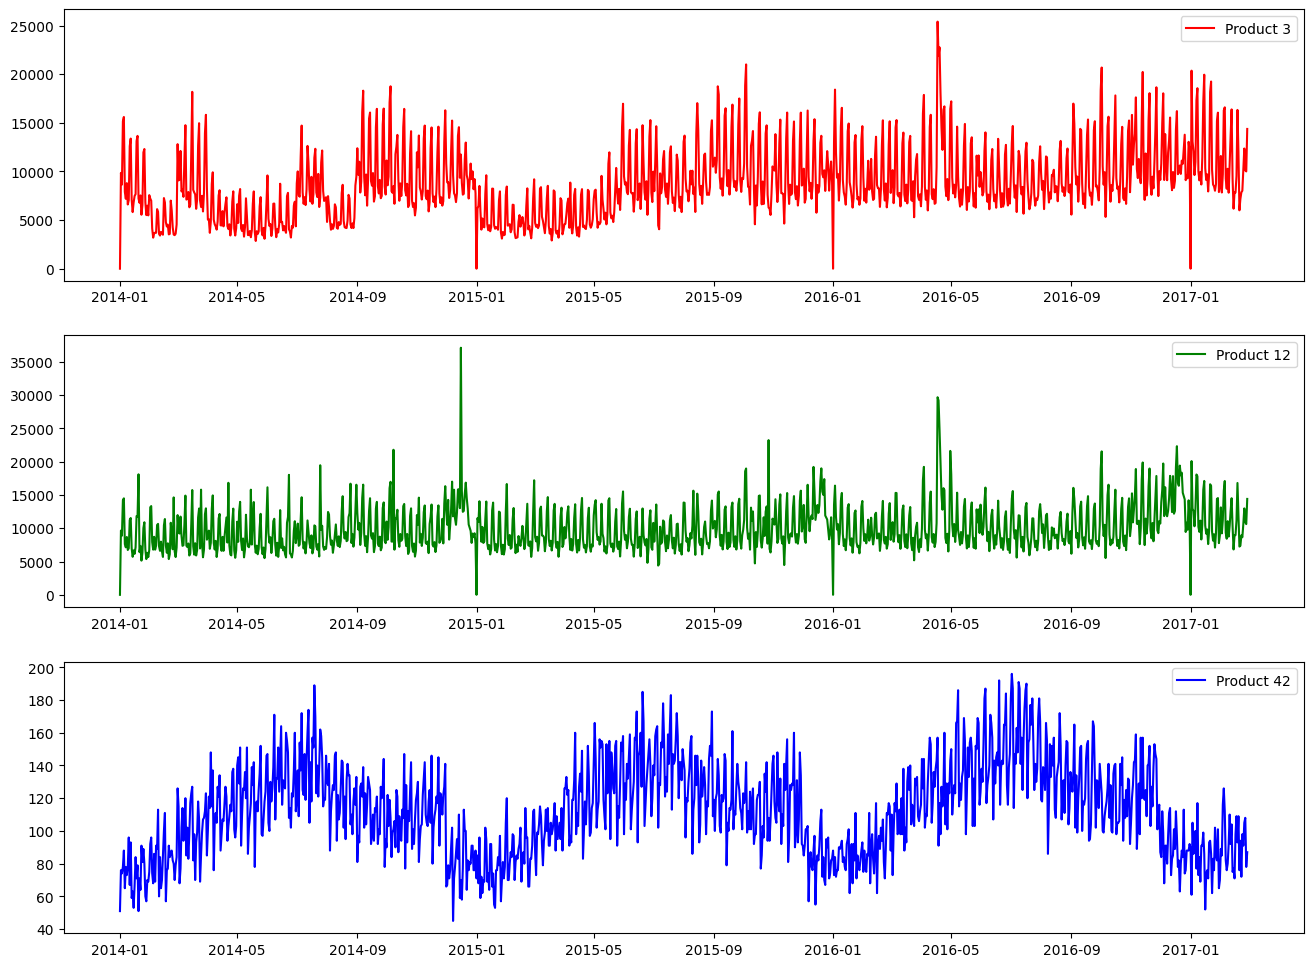

In [ ]:
plt.figure(figsize=[16,12])
plt.subplot(3,1,1)
plt.plot(data_44_3["Date"], data_44_3["Qty"], "r", label="Product 3")
plt.legend()
plt.subplot(3,1,2)
plt.plot(data_44_12["Date"], data_44_12["Qty"], "g", label="Product 12")
plt.legend()
plt.subplot(3,1,3)
plt.plot(data_44_42["Date"], data_44_42["Qty"], "b", label="Product 42")
plt.legend()
plt.show()

#### **<h1>분석 결과</h1>**

- 3번과 12번 상품의 경우 1월 1일 판매량이 없음. 추후 데이터 처리 필요

- 3번과 12번 상품은 전체 데이터로 볼 때는 경향성을 찾기 힘듦.

- 42번 상품은 등락이 어느정도 보이고, 그 기간이 4~11월로 수확이 잘되는 시기라고 생각이 듦.

### 2) 대상 상품의 동일 카테고리의 상품별 판매량 추이

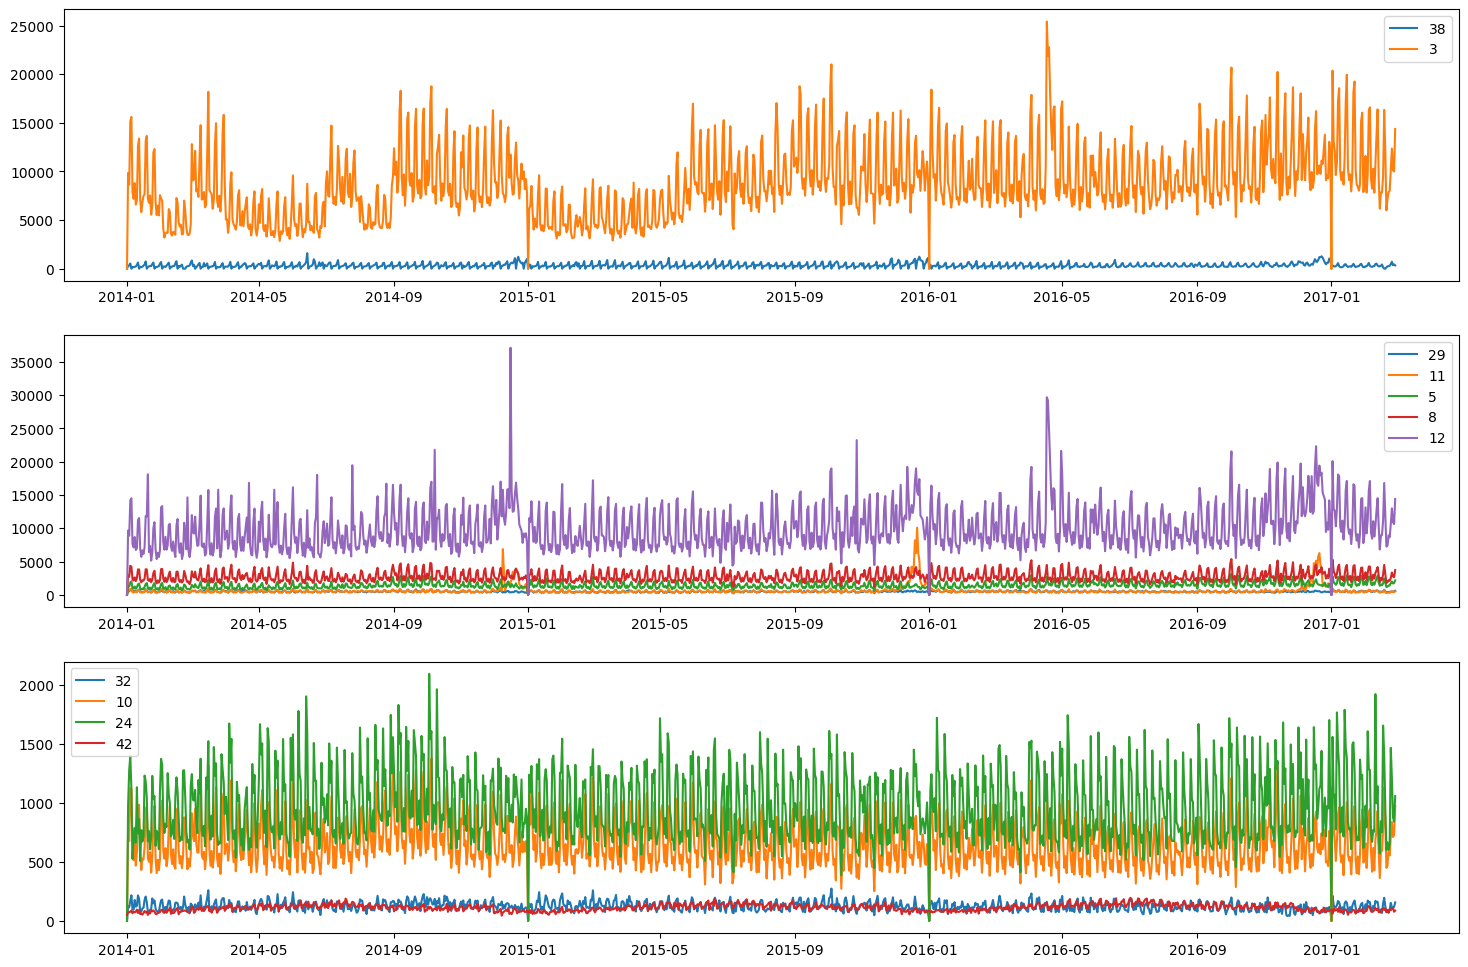

In [ ]:
category_3 = products[products["Product_ID"] == 3]["Category"].iloc[0]
category_12 = products[products["Product_ID"] == 12]["Category"].iloc[0]
category_42 = products[products["Product_ID"] == 42]["Category"].iloc[0]

same_category_products_3 = products[products["Category"] == category_3].Product_ID.to_list()
same_category_products_12 = products[products["Category"] == category_12].Product_ID.to_list()
same_category_products_42 = products[products["Category"] == category_42].Product_ID.to_list()

plt.figure(figsize=[18,12])
plt.subplot(3,1,1)
for product in same_category_products_3:
  temp = data_44[data_44.Product_ID == product]
  plt.plot(temp["Date"], temp["Qty"], label=product)
plt.legend()

plt.subplot(3,1,2)
for product in same_category_products_12:
  temp = data_44[data_44.Product_ID == product]
  plt.plot(temp["Date"], temp["Qty"], label=product)
plt.legend()

plt.subplot(3,1,3)
for product in same_category_products_42:
  temp = data_44[data_44.Product_ID == product]
  plt.plot(temp["Date"], temp["Qty"], label=product)
plt.legend()

#### **분석 결과**
- 3번과 12번의 경우 동일 카테고리 내 가장 많이 판매되는 상품
- 42번의 경우 grocery 카테고리 중 적게 팔리는 상품
- 42번이 미네소타(44번 상점)에서만 팔린다는 것을 고려할 때 해당 지역 특산품이지 않을까 추측됨.

### 3) 휘발유 가격과 상품 판매량 추이 비교

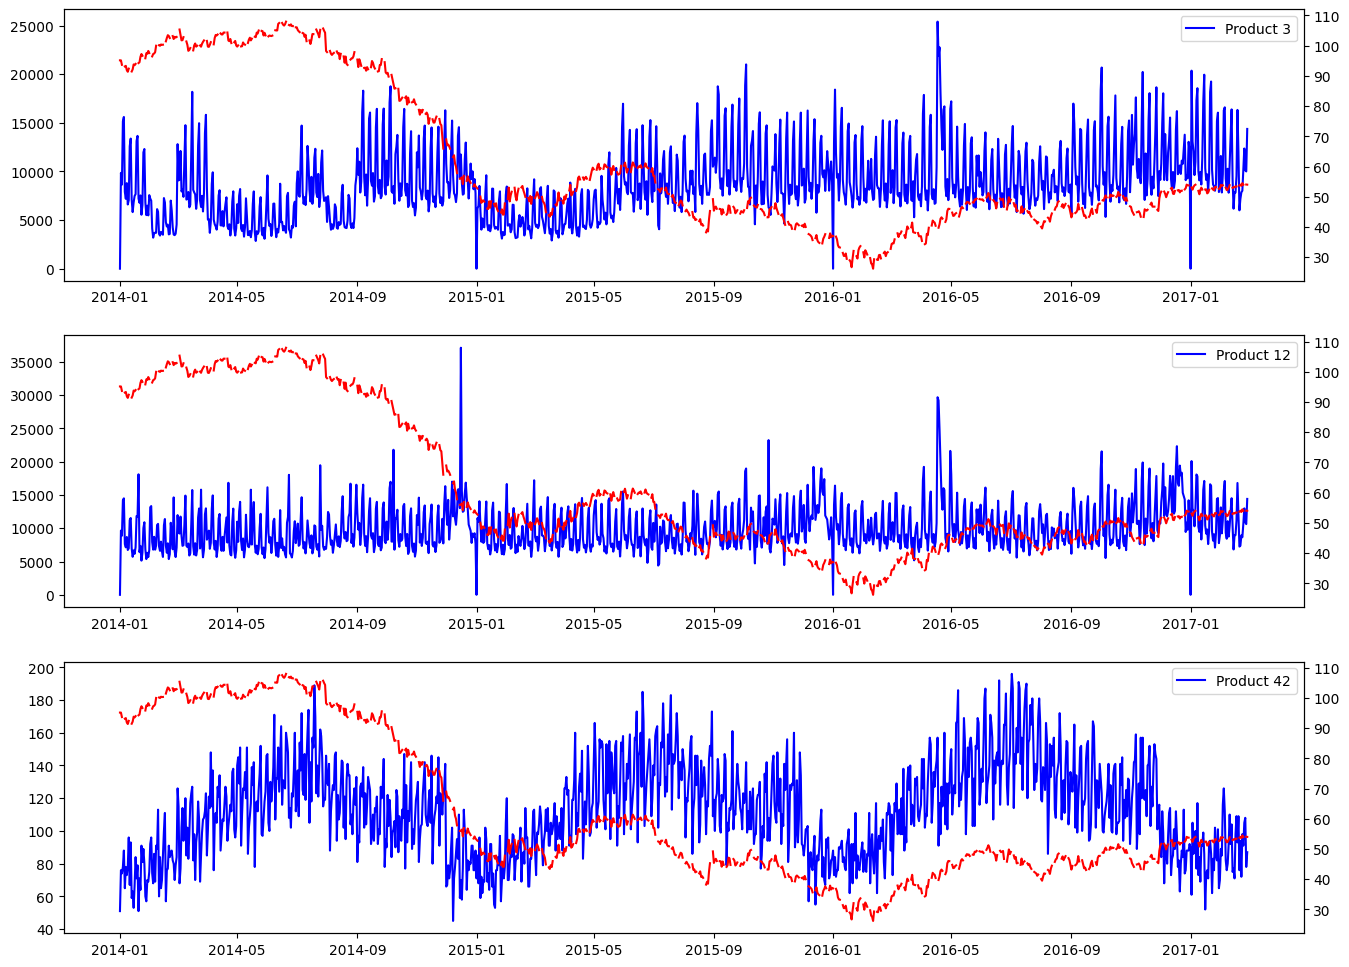

In [ ]:
plt.figure(figsize=[16,12])
ax = plt.subplot(3,1,1)
plt.plot(data_44_3["Date"], data_44_3["Qty"], "b", label="Product 3")
plt.legend()
ax2 = ax.twinx()
ax2.plot(data_44_3["Date"], data_44_3["WTI_Price"], "r", label="oil")

ax = plt.subplot(3,1,2)
plt.plot(data_44_12["Date"], data_44_12["Qty"], "b", label="Product 12")
plt.legend()
ax2 = ax.twinx()
ax2.plot(data_44_12["Date"], data_44_12["WTI_Price"], "r", label="oil")

ax = plt.subplot(3,1,3)
plt.plot(data_44_42["Date"], data_44_42["Qty"], "b", label="Product 42")
plt.legend()
ax2 = ax.twinx()
ax2.plot(data_44_42["Date"], data_44_42["WTI_Price"], "r", label="oil")

plt.show()

In [ ]:
## 유가와 2일간의 Qty 이동 평균
from scipy.stats import pearsonr

data_44_3["Qty_MA"] = data_44_3["Qty"].rolling(window=2, min_periods=1).mean()
data_44_12["Qty_MA"] = data_44_12["Qty"].rolling(window=2, min_periods=1).mean()
data_44_42["Qty_MA"] = data_44_42["Qty"].rolling(window=2, min_periods=1).mean()

correlation_3, p_value_3 = pearsonr(data_44_3.dropna()["WTI_Price"], data_44_3.dropna()["Qty_MA"])
print("product3 스피어만 상관계수:", correlation_3)
print("p-value:", p_value_3)

correlation_12, p_value_12 = pearsonr(data_44_12.dropna()["WTI_Price"], data_44_12.dropna()["Qty_MA"])
print("product12 스피어만 상관계수:", correlation_12)
print("p-value:", p_value_12)

correlation_42, p_value_42 = pearsonr(data_44_42.dropna()["WTI_Price"], data_44_42.dropna()["Qty_MA"])
print("product42 스피어만 상관계수:", correlation_42)
print("p-value:", p_value_42)

product3 스피어만 상관계수: -0.3286294555822447
p-value: 4.459550529775821e-22
product12 스피어만 상관계수: -0.18604851071256473
p-value: 8.17924996603369e-08
product42 스피어만 상관계수: -0.019541753820220335
p-value: 0.5765381469990826


#### **분석 결과**
- 그래프 상 유가와 상품 판매량은 크게 연관이 없어 보임.
- 간접적으로 영향을 받는 데이터이고, 유가도 외부요인에 의해 많이 변경이 되기에 비슷하지 않은 것으로 생각됨.
- 유가의 등락폭과 곡물 판매량의 등락을 알아보기 위해 2일간의 Qty 이동 평균과 유가의 상관계수를 확인해봄.
- 상관계수가 높은 편은 아니나 3, 12번의 p-value는 의미를 보임.

### 4) 방문 고객수와 상품 판매량 추이 비교

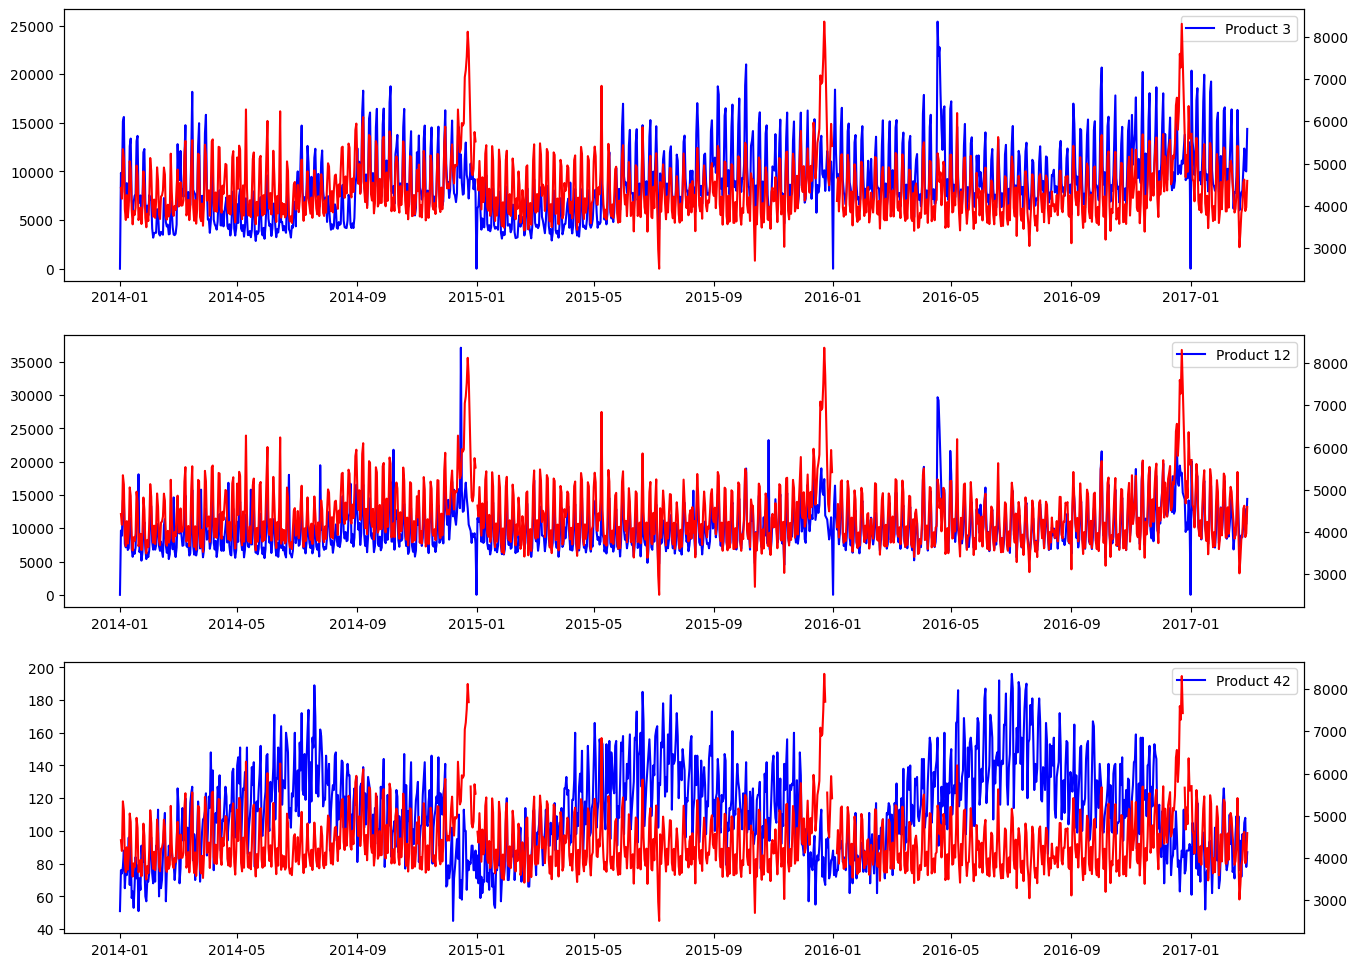

In [ ]:
plt.figure(figsize=[16,12])
ax = plt.subplot(3,1,1)
plt.plot(data_44_3["Date"], data_44_3["Qty"], "b", label="Product 3")
plt.legend()
ax2 = ax.twinx()
ax2.plot(data_44_3["Date"], data_44_3["CustomerCount"], "r", label="CustomerCount")

ax = plt.subplot(3,1,2)
plt.plot(data_44_12["Date"], data_44_12["Qty"], "b", label="Product 12")
plt.legend()
ax2 = ax.twinx()
ax2.plot(data_44_12["Date"], data_44_12["CustomerCount"], "r", label="CustomerCount")

ax = plt.subplot(3,1,3)
plt.plot(data_44_42["Date"], data_44_42["Qty"], "b", label="Product 42")
plt.legend()
ax2 = ax.twinx()
ax2.plot(data_44_42["Date"], data_44_42["CustomerCount"], "r", label="CustomerCount")

plt.show()

In [ ]:
correlation_3, p_value_3 = pearsonr(data_44_3.dropna()["CustomerCount"], data_44_3.dropna()["Qty"])
print("product3 스피어만 상관계수:", correlation_3)
print("p-value:", p_value_3)

correlation_12, p_value_12 = pearsonr(data_44_12.dropna()["CustomerCount"], data_44_12.dropna()["Qty"])
print("product12 스피어만 상관계수:", correlation_12)
print("p-value:", p_value_12)

correlation_42, p_value_42 = pearsonr(data_44_42.dropna()["CustomerCount"], data_44_42.dropna()["Qty"])
print("product42 스피어만 상관계수:", correlation_42)
print("p-value:", p_value_42)

product3 스피어만 상관계수: 0.3895076511343186
p-value: 4.5849139492668415e-31
product12 스피어만 상관계수: 0.5889721906485572
p-value: 1.2502692497588003e-77
product42 스피어만 상관계수: -0.17448615464244863
p-value: 5.049014789498064e-07


#### **분석 결과**
- 12번의 경우 고객수와 그래프가 어느정도 유사해보이며, 다른 두 상품은 크게 연관이 없어보임.
- 상관계수를 확인한 결과 12번은 어느정도 상관관계를 보이며, 다른 두 상품도 p-value를 고려할 때 관계는 있을 것으로 보임.

## **(2) 시계열 패턴 찾아보기2**

* 변화량과 비교해보기

### 1) 요일별 변화량 비교

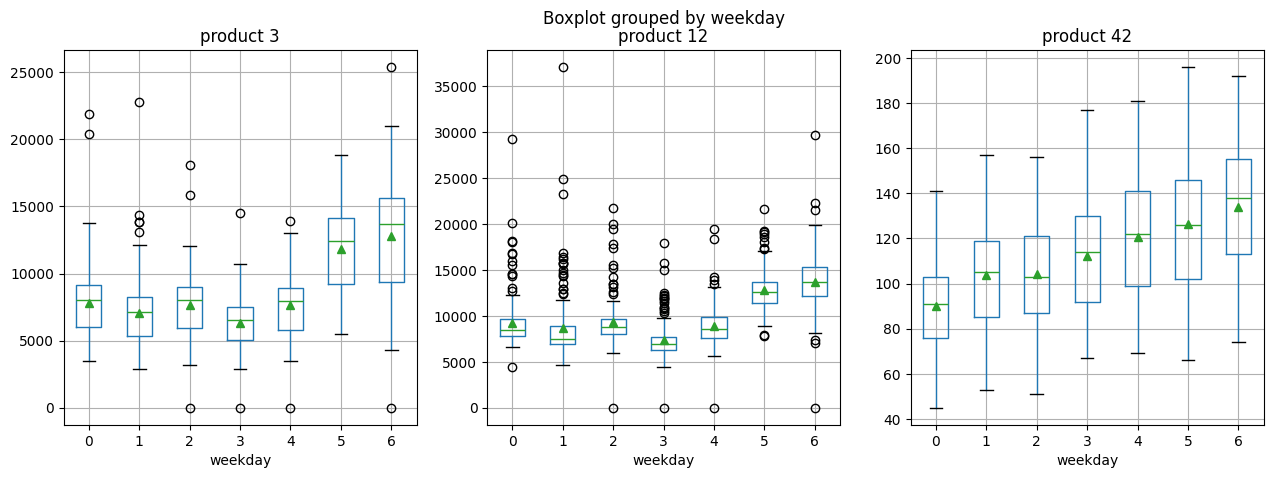

In [ ]:
plt.figure(figsize=[15, 5])
ax = plt.subplot(1,3,1)
data_44_3.boxplot(["Qty"], by="weekday", showmeans=True, ax=ax)
plt.title("product 3")

ax = plt.subplot(1,3,2)
data_44_12.boxplot(["Qty"], by="weekday", showmeans=True, ax=ax)
plt.title("product 12")

ax = plt.subplot(1,3,3)
data_44_42.boxplot(["Qty"], by="weekday", showmeans=True, ax=ax)
plt.title("product 42")

plt.show()

#### **분석 결과**
- 예상한 대로 평균 판매량은 주말이 전체적으로 높음. 허나 그만큼 편차도 큰 것으로 보임.
- 42번의 경우 주말에 가까워질수록 판매량이 증가하는 경향이 있음.

### 2) 월별 변화량 비교

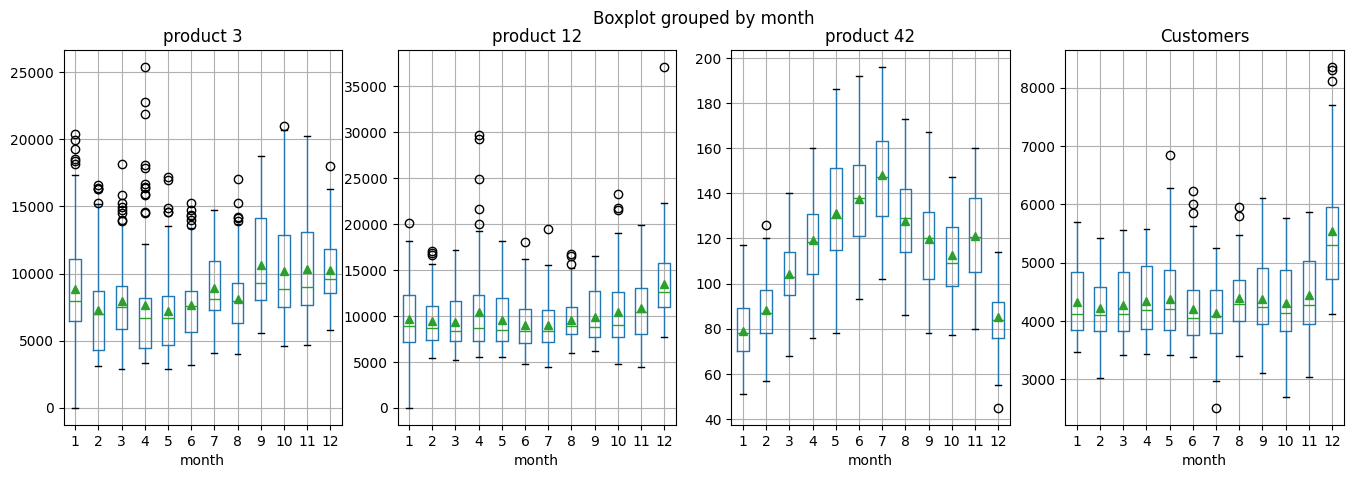

In [ ]:
plt.figure(figsize=[16, 5])
ax = plt.subplot(1,4,1)
data_44_3.boxplot(["Qty"], by="month", showmeans=True, ax=ax)
plt.title("product 3")

ax = plt.subplot(1,4,2)
data_44_12.boxplot(["Qty"], by="month", showmeans=True, ax=ax)
plt.title("product 12")

ax = plt.subplot(1,4,3)
data_44_42.boxplot(["Qty"], by="month", showmeans=True, ax=ax)
plt.title("product 42")

ax = plt.subplot(1,4,4)
data_44_42.boxplot(["CustomerCount"], by="month", showmeans=True, ax=ax)
plt.title("Customers")

plt.show()

#### **분석 결과**
- 3번 상품은 1월, 9~12월에 많이 팔리는 것으로 보아 기온이 낮을 때 많이 팔리는 음료로 보임.
- 12번 상품의 경우 12월에 약간은 많이 팔린 것으로 보이나 평균값과 편차가 생각보다 월별로 차이가 크지 않음.
- 42번 상품은 앞서 예상한대로 4~11월에 많이 팔리는 편. <br>
12월 고객 수가 증가하는 한 것이랑 관계가 없는 것으로 보아 판매량이 한정되어 있지 않을까 생각이 됨.

### 3) 공휴일별 변화량 비교

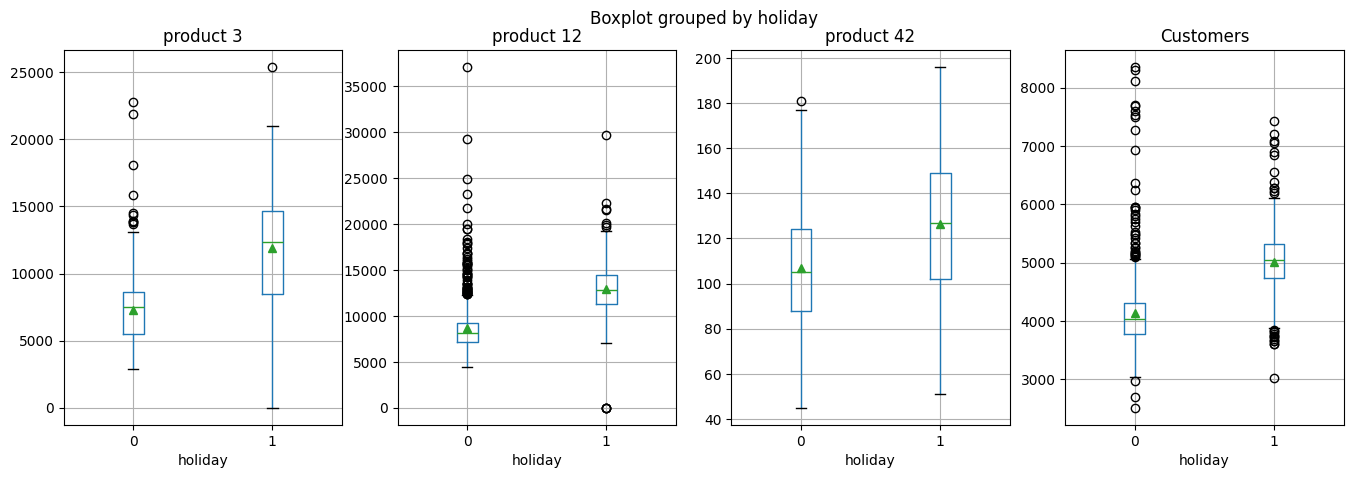

In [ ]:
plt.figure(figsize=[16, 5])
ax = plt.subplot(1,4,1)
data_44_3.boxplot(["Qty"], by="holiday", showmeans=True, ax=ax)
plt.title("product 3")

ax = plt.subplot(1,4,2)
data_44_12.boxplot(["Qty"], by="holiday", showmeans=True, ax=ax)
plt.title("product 12")

ax = plt.subplot(1,4,3)
data_44_42.boxplot(["Qty"], by="holiday", showmeans=True, ax=ax)
plt.title("product 42")

ax = plt.subplot(1,4,4)
data_44_42.boxplot(["CustomerCount"], by="holiday", showmeans=True, ax=ax)
plt.title("Customers")

plt.show()

In [ ]:
#### **분석 결과**
- 예상한대로 휴일에 더 많은 판매량을 보임.
- 42번의 경우에는 그 차이가 생각보다는 크지 않음.

# **3.패턴 정리하기**

* 다양한 탐색을 통해 찾은 시계열 패턴을 적어 봅시다.

## **1)상품 3에 대한 전체 분석 결과**

- 월별 변화량을 고려할 때 날씨에 영향을 받는 음료제품이지 않을까 생각이 됨.
- 휴일에 판매량이 많아지는 것으로 볼 때 휴일을 고려하여 입고를 해야함.

## **2)상품 12에 대한 전체 분석 결과**

- 12월에 고객수가 많아진다는 것을 고려할 때 월별로 차이가 크지 않은 것으로 보임.
- 대신 고객수와의 상관관계가 다른 상품보다 큰 것을 고려할 때, 보편적인 상품(일반 우유)로 추정됨.

## **3)상품 42에 대한 전체 분석 결과**

- grocery 제품인 것을 고려할 때 수확시기와 맞물려 판매량이 많아짐. - 이 시기에 입고량을 고려해야함.
- 고객수와의 관계가 크게 없어보임.
- 44번 상점에서만 판매하는 것과 수확과 맞물린다는 것을 고려할 때 미네소타 특산품이지 않을까 추측됨.

In [ ]:
sdate = sales.iloc[0]['Date']
edate = sales.iloc[-1]['Date']
period = 12

def decomp_plot(Product_ID, sdate, edate, period ) :

    # 시계열 데이터 분해
    temp = sales.loc[(sales['Store_ID'] == 44) & (sales['Product_ID'] == Product_ID) & (sales['Date'].between(sdate, edate))]
    decomp = sm.tsa.seasonal_decompose(temp['Qty'], model = 'additive', period = period)

    # 시계열 분해 결과를 받아서 데이터프레임으로 저장
    result = pd.DataFrame({'observed':decomp.observed, 'trend':decomp.trend, 'seasonal':decomp.seasonal, 'residual':decomp.resid})

    # 4개의 그래프로 나눠서 그리기
    plt.figure(figsize=(15, 8))

    plt.subplot(4,1,1)
    plt.plot(result['observed'])
    plt.ylabel('observed')

    plt.subplot(4,1,2)
    plt.plot(result['trend'])
    plt.ylabel('trend')

    plt.subplot(4,1,3)
    plt.plot(result['seasonal'])
    plt.ylabel('seasonal')

    plt.subplot(4,1,4)
    plt.plot(result['residual'])
    plt.ylabel('residual')
    plt.show()

    return result

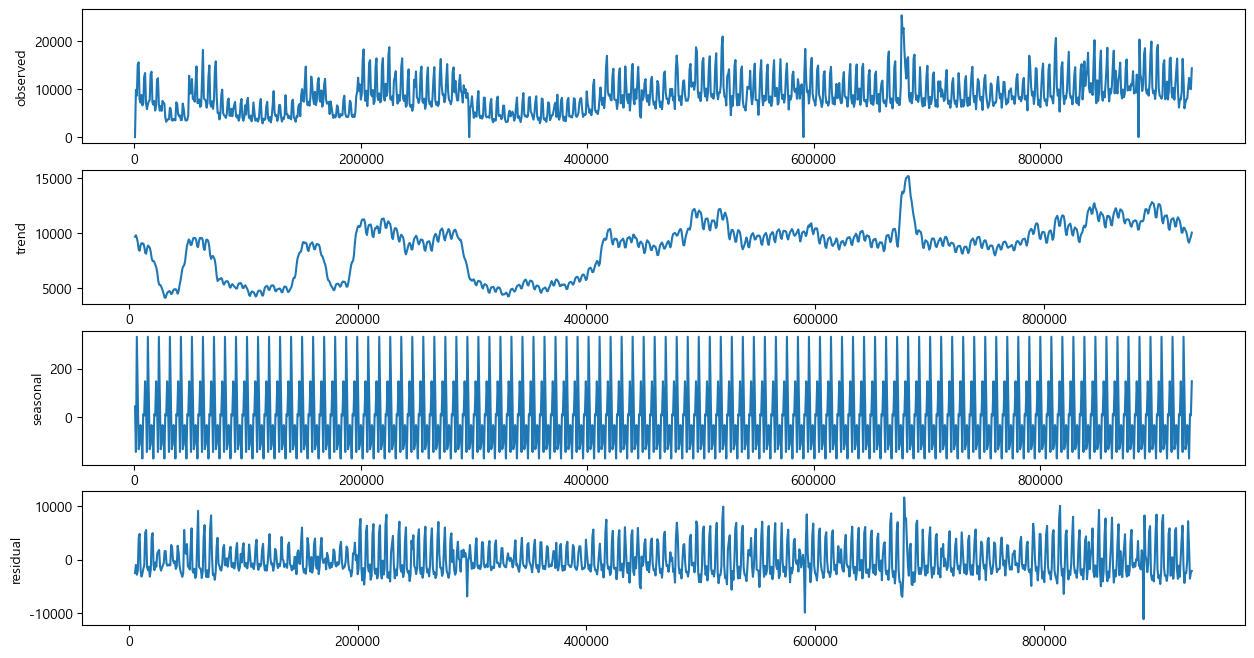

,observed,trend,seasonal,residual
645,0.0,NaN,44.768056,NaN
1456,9853.0,NaN,-142.055629,NaN
2267,8647.0,NaN,330.276389,NaN
3078,15153.0,NaN,90.716740,NaN
3889,15606.0,NaN,-130.749927,NaN
...,...,...,...,...
930865,10208.0,NaN,-49.544225,NaN
931676,12361.0,NaN,-168.697734,NaN
932487,10108.0,NaN,13.086915,NaN
933298,10006.0,NaN,7.333406,NaN


In [ ]:
result = decomp_plot(3, sdate, edate, period )
result